In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
from tqdm import tqdm

import numpy as np
import healpy as hp
from astropy.io import fits
from scipy.signal import convolve2d

sys.path.append("..")
import aatw.units_constants as uc

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## 0. set grid

In [2]:
pixel_size = np.deg2rad(0.25) # [rad]
b_edges = np.linspace(-np.pi/2, np.pi/2, 1+int(np.round(  np.pi/pixel_size)))
l_edges = np.linspace(-np.pi,   np.pi,   1+int(np.round(2*np.pi/pixel_size)))
b_s = (b_edges[:-1] + b_edges[1:]) / 2
l_s = (l_edges[:-1] + l_edges[1:]) / 2
l_grid, b_grid = np.meshgrid(l_s, b_s)

## 1. haslam residual

In [28]:
nu_haslam = 408 # [MHz]
beta = -2.5
T_min = 1e-3 # [K]

haslam_ds_map_hp = hp.read_map('../data/gsr/haslam408_ds_Remazeilles2014.fits')
haslam_dsds_map_hp = hp.read_map('../data/gsr/haslam408_dsds_Remazeilles2014.fits')
haslam_src_map_hp = np.maximum(haslam_ds_map_hp-haslam_dsds_map_hp, T_min)

haslam_src_map = hp.pixelfunc.get_interp_val(
    haslam_src_map_hp, np.rad2deg(l_grid), np.rad2deg(b_grid), lonlat=True
)

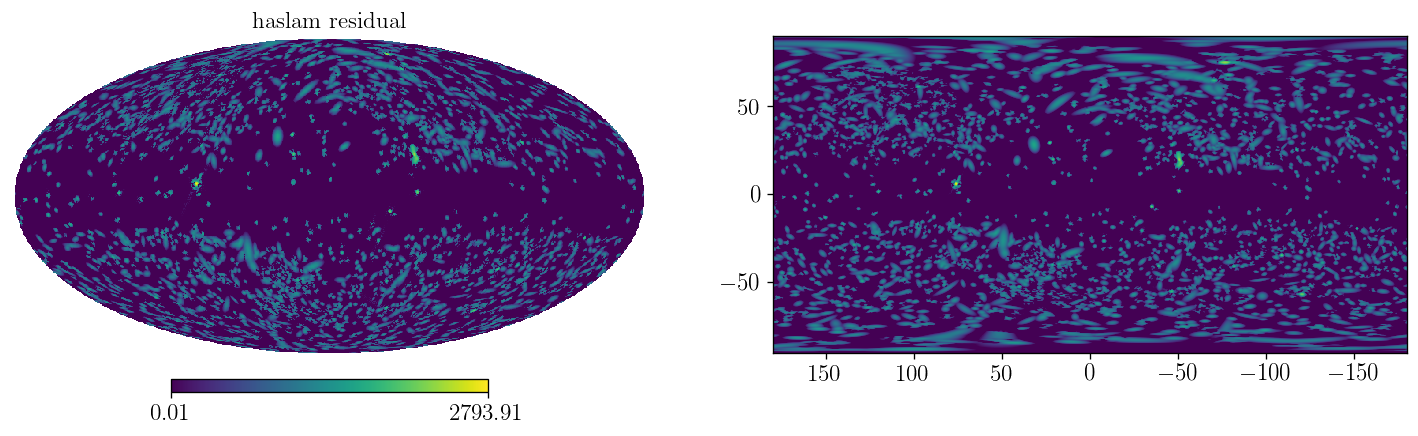

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plt.axes(axs[0])
hp.mollview(haslam_src_map_hp, hold=True, norm='log', min=1e-2, title='haslam residual')

axs[1].imshow(np.flip(np.log10(haslam_src_map)), vmin=-2, extent=(180, -180, -90, 90))

In [39]:
np.mean(haslam_src_map_hp)

0.388962

## 2. Keuhr catalog

In [3]:
with fits.open("../data/extragalactic/keuhr_catalog.fits") as hdul:
    data = hdul[1].data
len(data)

8602

In [4]:
data.dtype

dtype((numpy.record, {'names': ['NAME', 'RA', 'DEC', 'FREQUENCY', 'FLUX_RADIO', 'FLUX_RADIO_ERROR', 'CLASS', 'BII', 'COEFF_A', 'COEFF_A_ERROR', 'COEFF_B', 'COEFF_B_ERROR', 'COEFF_C', 'COEFF_C_ERROR', 'COEFF_D', 'FUNCTION_TYPE', 'LII', 'NAME_3C', 'POS_REF', 'REDSHIFT', 'REF_NUMBER', 'REF_NUMBER_SUFFIX', 'SPECTRAL_INDEX', 'SPECTRAL_INDEX_ERROR', 'VMAG'], 'formats': ['S10', 'S9', 'S9', 'S5', 'S10', 'S9', 'S12', 'S9', 'S6', 'S5', 'S5', 'S4', 'S7', 'S5', 'S2', 'S4', 'S9', 'S8', 'S2', 'S5', 'S3', 'S1', 'S5', 'S4', 'S5'], 'offsets': [0, 11, 21, 31, 37, 48, 58, 71, 81, 88, 94, 100, 105, 113, 119, 122, 127, 137, 146, 149, 155, 159, 161, 167, 172], 'itemsize': 177}))

In [7]:
data[10:20]['DEC']

array([-80.16491, -80.06248, -80.06248, -80.06248, -80.06248, -79.67646,
       -79.67646, -79.67646, -79.236  , -79.236  ])

In [ ]:
for d in data:
    if d['NAME'] == prev_name:
        continue
    else:
        prev_name = d['NAME']
    print(d['FREQUENCY'])

In [133]:
src_map = np.zeros_like(b_grid)
prev_name = ''

for d in data:
    if d['NAME'] == prev_name:
        continue
    else:
        prev_name = d['NAME']
    b = np.deg2rad(d['BII']) # [rad]
    l = np.deg2rad(d['LII']) # [rad]
    l = l if l < np.pi else l - 2*np.pi

    if d['FUNCTION_TYPE'] == 'LIN':
        Snu = 10**(d['COEFF_A'] + d['COEFF_B'] * np.log10(nu_haslam)) # [Jy]
    # elif d['FUNCTION_TYPE'] == 'EXP':
    #     Snu = 10**(d['COEFF_A'] + d['COEFF_B'] * np.log10(nu_haslam) + d['COEFF_C'] * np.exp(d['COEFF_D']) * np.log10(nu_haslam)) # [Jy]
    else:
        nu = d['FREQUENCY'] # [MHz]
        si = d['SPECTRAL_INDEX']
        Snu = d['FLUX_RADIO']/1000 * (nu_haslam/nu)**si # [Jy]
        
    pixel_area = pixel_size ** 2 * np.cos(b) # [rad^2]
    I = Snu/pixel_area # [Jy sr^-1]
    # I = 2 * nu^2 kb T / c0^2
    # [MHz^2 g sr^-1] = [MHz^2] [cm^2 MHz^2 g] [cm^-2 MHz^-2]
    T = I * uc.Jy / (2 * nu_haslam**2 * uc.kb / uc.c0**2)

    i_b = np.searchsorted(b_edges[:-1], b) - 1
    i_l = np.searchsorted(l_edges[:-1], l) - 1
    if T > 1e5:
        print(d['NAME'], T, d['COEFF_A'], d['COEFF_B'], d['COEFF_C'], d['COEFF_D'])
    src_map[i_b, i_l] += T

In [91]:
n_sigma = 5
kernel_size = np.deg2rad(0.5) # [rad]
n_pix = int(np.round(2*n_sigma*kernel_size/pixel_size)) - 1
kernel = np.zeros((n_pix, n_pix))
i_c = (n_pix-1) / 2
for i in range(n_pix):
    for j in range(n_pix):
        kernel[i, j] = np.exp(- ((i-i_c)**2+(j-i_c)**2) / (2 * (kernel_size/pixel_size)**2))
kernel /= np.sum(kernel)

In [134]:
src_map_smoothed = convolve2d(src_map, kernel, mode='same')

In [135]:
np.mean(src_map), np.mean(src_map_smoothed)

(0.110751974047617, 0.1104221232546403)

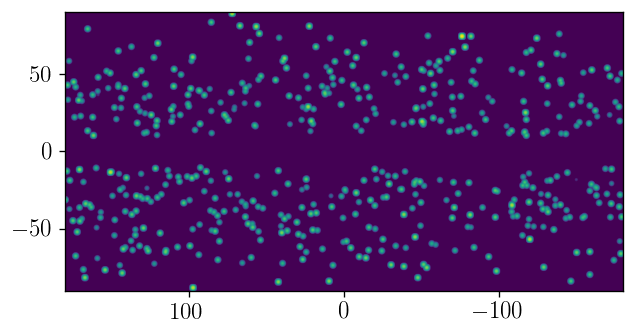

In [136]:
plt.imshow(np.flip(np.log10(np.clip(src_map_smoothed, 1e-5, None))), extent=(180, -180, -90, 90))